In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\facebook_metrices\dataset_Facebook.csv", delimiter =';')
# data.describe

df.columns = ['_'.join(name.split(' ')) for name in df.columns]

print(df.isnull().sum())
print(df.count())

Page_total_likes                                                       0
Type                                                                   0
Category                                                               0
Post_Month                                                             0
Post_Weekday                                                           0
Post_Hour                                                              0
Paid                                                                   1
Lifetime_Post_Total_Reach                                              0
Lifetime_Post_Total_Impressions                                        0
Lifetime_Engaged_Users                                                 0
Lifetime_Post_Consumers                                                0
Lifetime_Post_Consumptions                                             0
Lifetime_Post_Impressions_by_people_who_have_liked_your_Page           0
Lifetime_Post_reach_by_people_who_like_your_Page   

In [36]:
df.dtypes

Page_total_likes                                                         int64
Type                                                                    object
Category                                                                 int64
Post_Month                                                               int64
Post_Weekday                                                             int64
Post_Hour                                                                int64
Paid                                                                   float64
Lifetime_Post_Total_Reach                                                int64
Lifetime_Post_Total_Impressions                                          int64
Lifetime_Engaged_Users                                                   int64
Lifetime_Post_Consumers                                                  int64
Lifetime_Post_Consumptions                                               int64
Lifetime_Post_Impressions_by_people_who_have_liked_y

In [37]:
df['Paid'] = df['Paid'].fillna(df['Paid'].mean())
df['like'] = df['like'].fillna(df['like'].mean())
df.count()

Page_total_likes                                                       500
Type                                                                   500
Category                                                               500
Post_Month                                                             500
Post_Weekday                                                           500
Post_Hour                                                              500
Paid                                                                   500
Lifetime_Post_Total_Reach                                              500
Lifetime_Post_Total_Impressions                                        500
Lifetime_Engaged_Users                                                 500
Lifetime_Post_Consumers                                                500
Lifetime_Post_Consumptions                                             500
Lifetime_Post_Impressions_by_people_who_have_liked_your_Page           500
Lifetime_Post_reach_by_pe

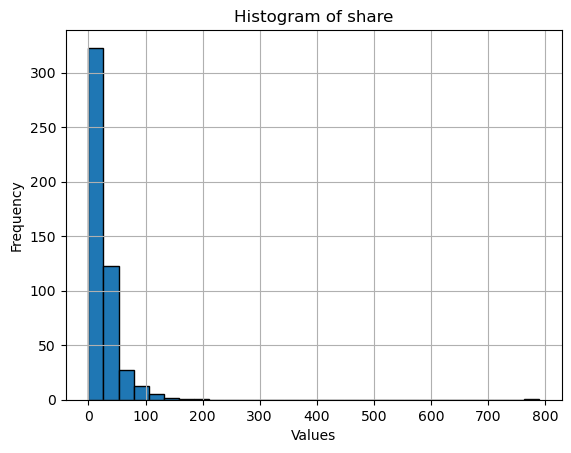

count    496.000000
mean      27.266129
std       42.613292
min        0.000000
25%       10.000000
50%       19.000000
75%       32.250000
max      790.000000
Name: share, dtype: float64

In [38]:
df['share'].hist(bins=30, edgecolor='black')
plt.title('Histogram of share')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()
df['share'].describe()

In [39]:
df['share'] = df['share'].fillna(df['share'].mean())
df.count()

Page_total_likes                                                       500
Type                                                                   500
Category                                                               500
Post_Month                                                             500
Post_Weekday                                                           500
Post_Hour                                                              500
Paid                                                                   500
Lifetime_Post_Total_Reach                                              500
Lifetime_Post_Total_Impressions                                        500
Lifetime_Engaged_Users                                                 500
Lifetime_Post_Consumers                                                500
Lifetime_Post_Consumptions                                             500
Lifetime_Post_Impressions_by_people_who_have_liked_your_Page           500
Lifetime_Post_reach_by_pe

In [40]:
df.isna().sum()

Page_total_likes                                                       0
Type                                                                   0
Category                                                               0
Post_Month                                                             0
Post_Weekday                                                           0
Post_Hour                                                              0
Paid                                                                   0
Lifetime_Post_Total_Reach                                              0
Lifetime_Post_Total_Impressions                                        0
Lifetime_Engaged_Users                                                 0
Lifetime_Post_Consumers                                                0
Lifetime_Post_Consumptions                                             0
Lifetime_Post_Impressions_by_people_who_have_liked_your_Page           0
Lifetime_Post_reach_by_people_who_like_your_Page   

In [41]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

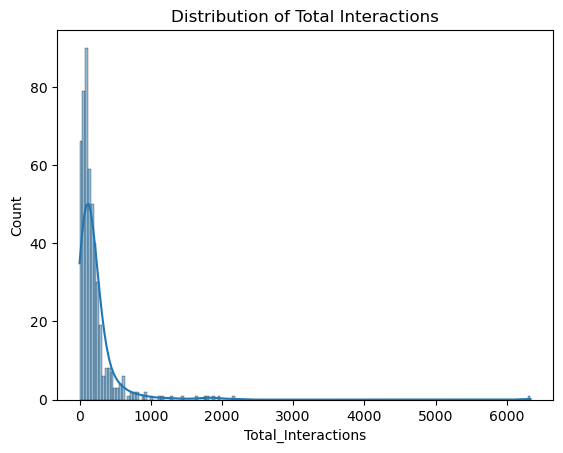

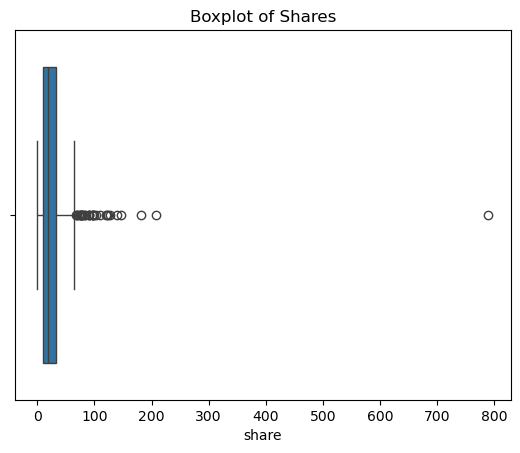

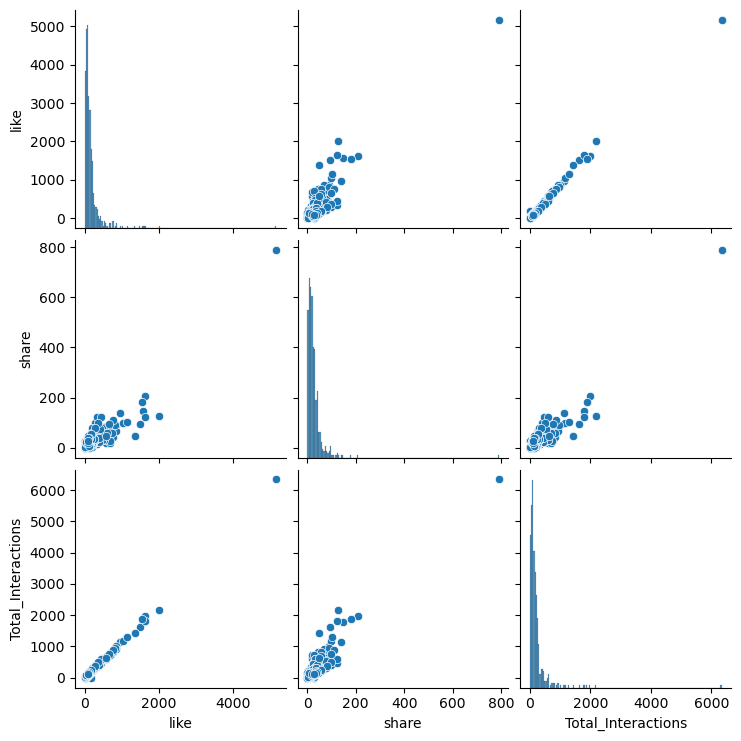

In [42]:
import seaborn as sns

sns.histplot(df['Total_Interactions'], kde=True)
plt.title('Distribution of Total Interactions')
plt.show()

sns.boxplot(x=df['share'])
plt.title('Boxplot of Shares')
plt.show()

sns.pairplot(df[['like', 'share', 'Total_Interactions']])
plt.show()


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Feature Engineering
df_fe = df.copy()

df_fe['engagement_rate'] = df_fe['Total_Interactions'] / df_fe['Lifetime_Post_Total_Impressions']
# df_fe['is_weekend'] = df_fe['Post_Weekday'].apply(lambda x: 1 if x in [6, 7] else 0)
df_fe['interactions_per_hour'] = df_fe['Total_Interactions'] / df_fe['Post_Hour']

# 2. Define Features and Targets
features = ['Page_total_likes',
            'Post_Hour', 'Lifetime_Post_Total_Reach',
            'Lifetime_Post_Total_Impressions', 'Lifetime_Engaged_Users',
            'Lifetime_People_who_have_liked_your_Page_and_engaged_with_your_post',
            'engagement_rate', 'interactions_per_hour']

targets = ['like', 'share',  'Total_Interactions']

df_log = df_fe.copy()

for col in features:
    df_log[col] = np.log1p(df_log[col])  # log1p = log(1 + x)

# Optional: Log-transform targets (use only if targets are highly skewed)
log_targets = True
if log_targets:
    for col in targets:
        df_log[col] = np.log1p(df_log[col])

# Define X and y
X = df_log[features]
y = df_log[targets]

# 3. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Define and Train Model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# 6. Make Predictions
y_pred = model.predict(X_test)

if log_targets:
    y_test = np.expm1(y_test)     # exp(x) - 1
    y_pred = np.expm1(y_pred)

# 7. Evaluate Model
for i, col in enumerate(targets):
    print(f"\n----- {col.upper()} -----")
    print("R² Score:", r2_score(y_test[col], y_pred[:, i]))
    print("MSE:", mean_squared_error(y_test[col], y_pred[:, i]))



----- LIKE -----
R² Score: 0.8734122929899767
MSE: 5799.093483126324

----- SHARE -----
R² Score: 0.6041690384307199
MSE: 181.3181581472554

----- TOTAL_INTERACTIONS -----
R² Score: 0.8834997082801397
MSE: 6311.232875646675


Checking Feature Importance for each target

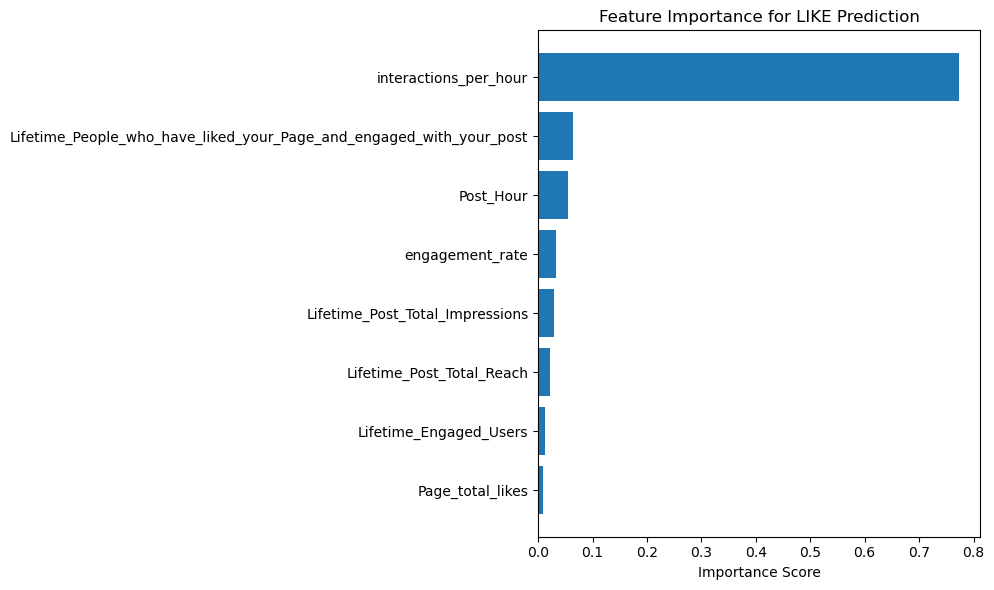

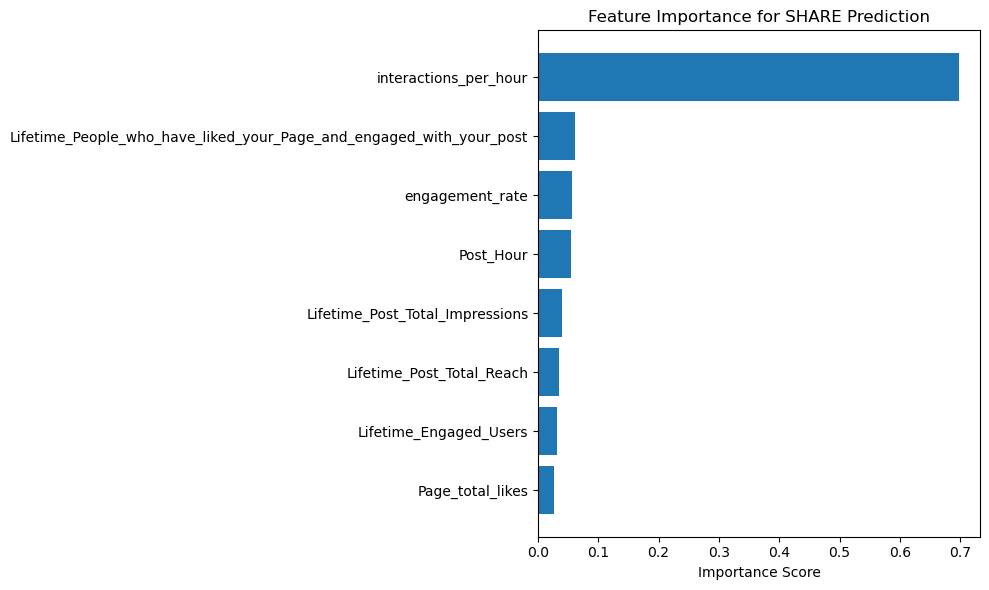

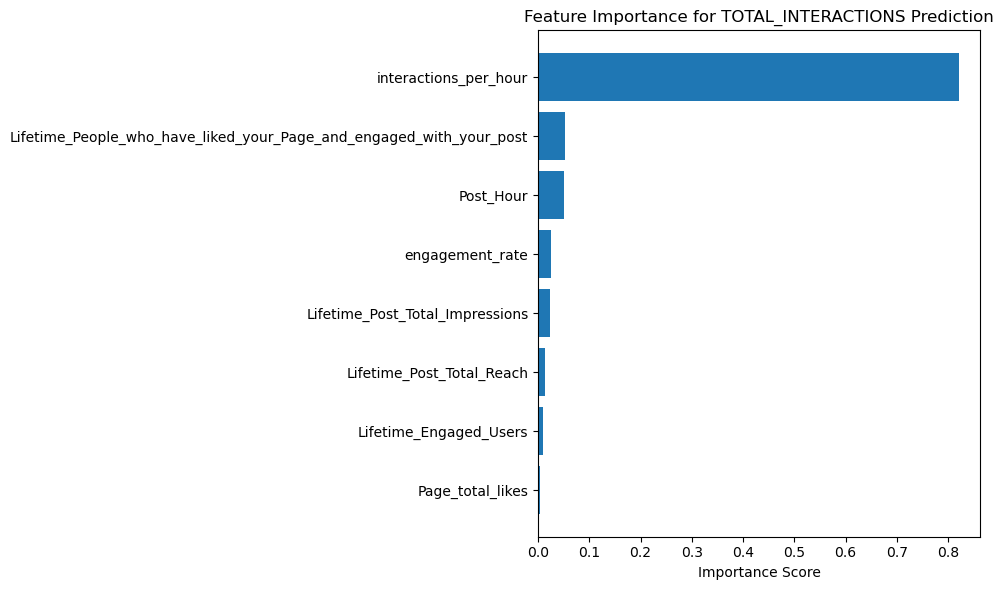

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names
feature_names = features

# Target names and corresponding estimator index
target_names = ['like', 'share', 'Total_Interactions']

# Plot feature importance for each target
for i, target in enumerate(target_names):
    estimator = model.estimators_[i]
    importances = estimator.feature_importances_
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.title(f"Feature Importance for {target.upper()} Prediction")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


In [45]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

pickle.dump(scaler, open('scaler.pkl', 'wb'))